In [11]:
import json
from transformers import LlamaTokenizerFast
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
tokenizer = LlamaTokenizerFast.from_pretrained("hf-internal-testing/llama-tokenizer")

In [6]:
def num_tokens_from_string(string):
    return len(tokenizer.encode(string))

In [12]:
def calculate_length(path):
    with open(path, 'r') as f:
        data = json.load(f)
    lengths = []
    for meeting in tqdm(data):
        lengths.append(num_tokens_from_string(meeting['source']))
    return lengths

In [13]:
def min_max_avg(numbers):
    min_val = min(numbers)
    max_val = max(numbers)
    avg_val = sum(numbers) / len(numbers)
    return min_val, max_val, avg_val

In [14]:
def plot_lengths(lengths):
    plt.hist(lengths, bins=100)
    plt.show()

100%|██████████| 1000/1000 [13:37<00:00,  1.22it/s]


train: min=29, max=116791, avg=24169.134


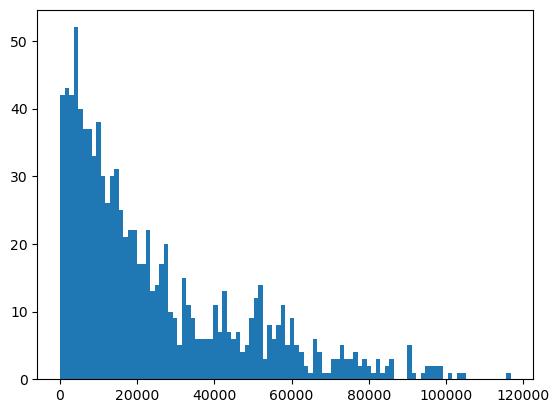

In [15]:
# train
train_lengths = calculate_length('train_meeting.json')
min_val, max_val, avg_val = min_max_avg(train_lengths)
print(f'train: min={min_val}, max={max_val}, avg={avg_val}')
plot_lengths(train_lengths)

In [19]:
shortest_string = min(train_lengths)
print(train_lengths.index(shortest_string))

155


100%|██████████| 125/125 [01:46<00:00,  1.18it/s]

test: min=379, max=107503, avg=24681.68


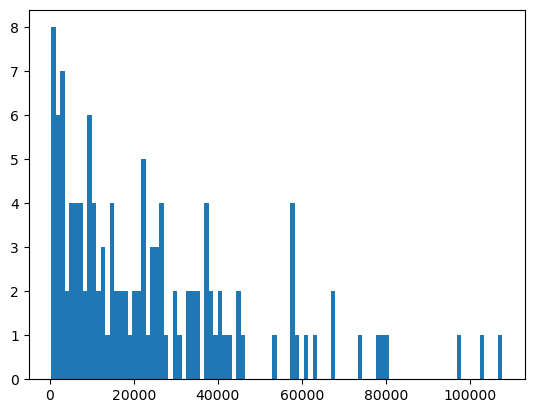

In [16]:
# test
test_lengths = calculate_length('test_meeting.json')
min_val, max_val, avg_val = min_max_avg(test_lengths)
print(f'test: min={min_val}, max={max_val}, avg={avg_val}')
plot_lengths(test_lengths)

100%|██████████| 125/125 [01:51<00:00,  1.12it/s]


val: min=528, max=117026, avg=24952.912


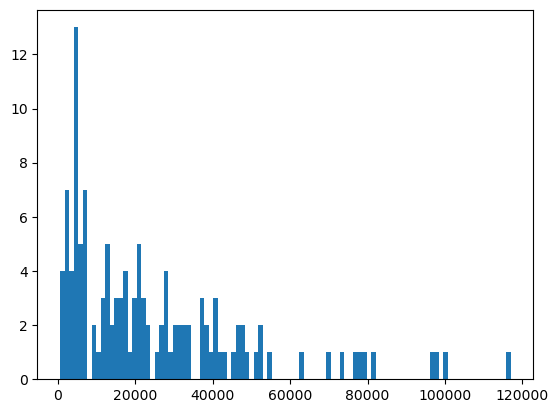

In [17]:
# val
val_lengths = calculate_length('validation_meeting.json')
min_val, max_val, avg_val = min_max_avg(val_lengths)
print(f'val: min={min_val}, max={max_val}, avg={avg_val}')
plot_lengths(val_lengths)